In [25]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import scipy.optimize
π = np.pi

# Specifying and fitting models

* [Climate probability model](#Climate-probability-model)
* [Galaxies probability model (Gaussian mixture model)](#Galaxies-probability-model-(Gaussian-mixture-model))
* [Fitting a Gaussian mixture model](#Fitting-a-Gaussian-mixture-model)
* [Numerical optimization with scipy](#Numerical-optimization-with-scipy)
  * [Exercise from lecture notes.](#Exercise-from-lecture-notes.)
  * [Exercise from lecture notes.](#Exercise-from-lecture-notes.)
* [Generative models and goodness-of-fit](#Generative-models-and-goodness-of-fit)
* [Supervised learning: straight-line fit](#Supervised-learning:-straight-line-fit)

# Climate probability model

This dataset has one record per station per month. Different stations have different lengths of records: some start at 1853, the most recent starts in 1978. Source: the UK Met Office. See the accompanying file [climate.ipynb](climate.ipynb) for scraping code.

In [7]:
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/climate.csv'
climate = pandas.read_csv(url)

# Define a timestamp, measured in years
climate['t'] = climate.yyyy + (climate.mm-1)/12

# Restrict attention to recent records from Cambridge
df = climate.loc[(climate.station=='Cambridge') & (climate.yyyy>=1985)]

# How long do the records go back, for each station?
# climate.groupby('station').apply(lambda df: min(df.yyyy)).sort_values()

Here is a probability model for temperature, first in random variable notation and below in code:
$$
\textit{Temp}_i = \alpha \sin\bigl(2\pi(t+\phi)\bigr) + c + \gamma t + \operatorname{Normal}(0,\sigma^2)
$$
The code chooses plausible values for the unknown parameters. Plug in different parameters and see if you can get a better fit.

In [9]:
def rtemp(t, α=9, φ=-0.25, c=10, γ=0, σ=2):
    pred = α*np.sin(2*π*(t+φ)) + c + γ*t
    return np.random.normal(loc=pred, scale=σ)

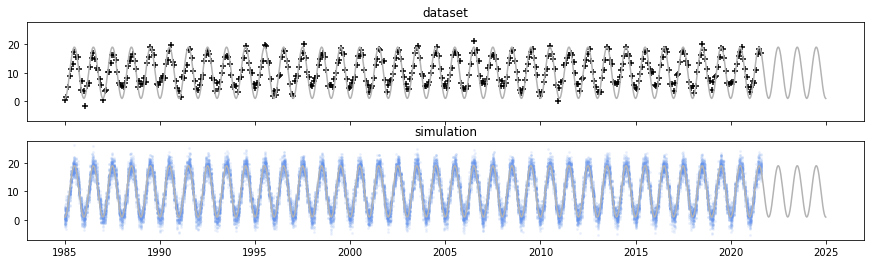

In [14]:
fig,(ax,ax2) = plt.subplots(2,1, figsize=(15,4), sharex=True, sharey=True)

# Plot the (noiseless) predicted sinusoid
newt = np.linspace(1985, 2025, 1000)
ax.plot(newt, rtemp(newt, σ=0), color='0.7')
ax2.plot(newt, rtemp(newt, σ=0), color='0.7')

# Scatter-plot the actual data
ax.scatter(df.t, df.temp, color='black', marker='+')
ax.set_title('dataset')

# Scatter-plot some simulated data
for _ in range(60):
    ax2.scatter(df.t, rtemp(df.t), color='cornflowerblue', marker='o', s=3, alpha=0.1)
ax2.set_title('simulation')
    
plt.show()

# Galaxies probability model (Gaussian mixture model)

This dataset contains the radial velocity, as seen from earth, of 120 galaxies in the Corona Borealis area of the sky. Source: [Postman, Huchra, and Geller, 1986](https://ui.adsabs.harvard.edu/abs/1986AJ.....92.1238P).

In [67]:
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/galaxies_orig.csv'
galaxies = pandas.read_csv(url)
galaxies = galaxies['velocity'].values
len(galaxies)

120

We propose the following probability model for a random galaxy speed $X$:
$$
K \sim \operatorname{Cat}\bigl([p_1,p_2,p_3]\bigr),
\quad
X \sim \operatorname{Normal}(\mu_K, \sigma_K^2).
$$

In [23]:
def rgalaxies(size, p, μ, σ):
    res = []
    for _ in range(size):
        cluster = np.random.choice([0,1,2], p=p)
        μi,σi = μ[cluster], σ[cluster]
        x = np.random.normal(loc=μi, scale=σi)
        res.append(x)
    return res

# Exercise: rewrite rgalaxies to use vectorized numpy

p = [0.28, 0.54, 0.18]
μ = [9740, 21300, 15000]
σ = [340, 1700, 10600]

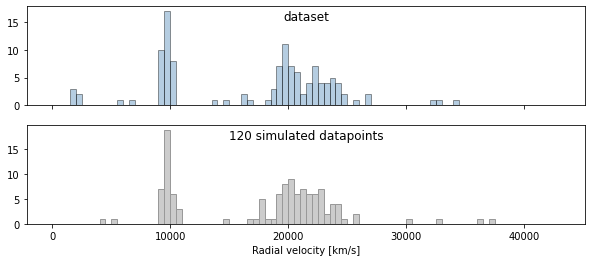

In [24]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True)

ax1.hist(galaxies, bins=np.linspace(0,43000,87), color='steelblue', alpha=.4, ec='black')
ax1.set_title('dataset', y=0.8)

ax2.hist(rgalaxies(120,p,μ,σ), bins=np.linspace(0,43000,87), color='0.8', ec='0.6')
ax2.set_title('120 simulated datapoints', y=0.8)

ax2.set_xlabel('Radial velocity [km/s]')
plt.show()

# Fitting a Gaussian mixture model

We'll maximize the likelihood over
$$
\theta = (q_1,q_2,\;\mu_1,\mu_2,\mu_3,\;\tau_1,\tau_2,\tau_3) \in \mathbb{R}^8
$$
transformed into the parameters of the model by
$$
[p_1,p_2,p_3]=\operatorname{softmax}([q_1,q_2,0]),
\quad \sigma_k = e^{\tau_k}
$$

Optimization terminated successfully.
         Current function value: 1152.253635
         Iterations: 1878
         Function evaluations: 2777


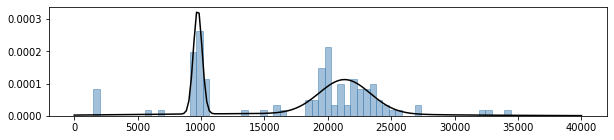

In [73]:
def transform_par(θ):
    q1,q2, μ1,μ2,μ3, τ1,τ2,τ3 = θ
    p = np.exp([q1,q2,0])
    p1,p2,p3 = p / np.sum(p)
    σ1,σ2,σ3 = np.exp([τ1,τ2,τ3])
    return (p1,p2,p3), (μ1,μ2,μ3), (σ1,σ2,σ3)

def logPr(x, θ):
    (p1,p2,p3),(μ1,μ2,μ3),(σ1,σ2,σ3) = transform_par(θ)
    φ = scipy.stats.norm.pdf
    lik = p1*φ(x,loc=μ1,scale=σ1) + p2*φ(x,loc=μ2,scale=σ2) + p3*φ(x,loc=μ3,scale=σ3)
    return np.log(lik)

initial_guess = [0,0, 10000,20000,24000, np.log(1000),np.log(5000),np.log(8000)]
θhat = scipy.optimize.fmin(lambda θ: - np.sum(logPr(galaxies, θ)), initial_guess, maxiter=5000)
# print(transform_par(θhat))

fig,ax = plt.subplots(figsize=(10,2))
x = np.linspace(0,40000,200)
f = np.exp(logPr(x, θhat))
ax.plot(x, f, color='black')
ax.hist(galaxies, bins = np.linspace(0,40000,80), density=True, ec='steelblue', fc='steelblue', alpha=.5)
plt.show()

# Numerical optimization with scipy

### Exercise from lecture notes.
Find the maximum over $\sigma>0$ of
$$
f(\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-3/2\sigma^2}.
$$

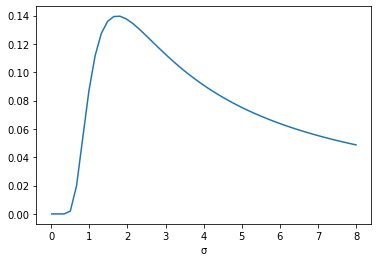

Optimization terminated successfully.
         Current function value: -0.139702
         Iterations: 13
         Function evaluations: 26


1.7320498691939412

In [28]:
# We'll do the optimization over τ ∈ ℝ, and transform to σ>0 by σ=e^τ.

def f(τ):
    σ = np.exp(τ)
    return np.exp(-3/2/np.power(σ,2)) / np.sqrt(2*π*np.power(σ,2))

fig,ax = plt.subplots()
σ = np.linspace(.01,8,50)
ax.plot(σ, f(np.log(σ)))
ax.set_xlabel('σ')
plt.show()

# From the plot, the maximum is somewhere around σ=2.
# Choose the initial guess for τ accordingly.

(τhat,) = scipy.optimize.fmin(lambda τ: -f(τ), np.log(2))
σhat = np.exp(τhat)
σhat

### Exercise from lecture notes.
Find the maximum of
$$
f(p_1,p_2,p_3) = 0.2\log p_1 + 0.5\log p_2 + 0.3\log p_3
$$
over $p_1,p_2,p_3\in(0,1)$ such that $p_1+p_2+p_3=1$.

In [30]:
# We'll optimize over s1,s2,s3 ∈ ℝ, and transform to p1,p2,p3 using the softmax transform.

def f(θ):
    s1,s2,s3 = θ
    p = np.exp([s1,s2,s3])
    p1,p2,p3 = p / np.sum(p)
    return 0.2*np.log(p1) + 0.5*np.log(p2) + 0.3*np.log(p3)

s1,s2,s3 = scipy.optimize.fmin(lambda θ: -f(θ), [0,0,0])
p = np.exp([s1,s2,s3])
p = p / np.sum(p)
p

Optimization terminated successfully.
         Current function value: 1.029653
         Iterations: 75
         Function evaluations: 140


array([0.19999857, 0.50001036, 0.29999106])

# Generative models and goodness-of-fit

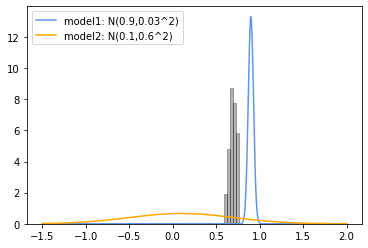


model1:  loglik=-708.4   avg.err=0.214
model2:  loglik=-26.64   avg.err=0.586



In [65]:
# A dataset (generated reproducibly)
rng = np.random.default_rng(seed=10)
x = rng.normal(loc=0.7, scale=0.05, size=30)

# Two possible models
model1 = scipy.stats.norm(loc=0.9, scale=0.03)
model2 = scipy.stats.norm(loc=0.1, scale=0.6)

fig,ax = plt.subplots()
ax.hist(x, bins=np.linspace(0,1,30), density=True, ec='black', fc='black', alpha=.3)
xsamp = np.linspace(-1.5, 2, 1000)
ax.plot(xsamp, model1.pdf(xsamp), color='cornflowerblue', label='model1: N(0.9,0.03^2)')
ax.plot(xsamp, model2.pdf(xsamp), color='orange', label='model2: N(0.1,0.6^2)')
plt.legend()

plt.show()

print(f'''
model1:  loglik={np.sum(model1.logpdf(x)):.4}   avg.err={np.mean(np.abs(x - model1.mean())):.3}
model2:  loglik={np.sum(model2.logpdf(x)):.4}   avg.err={np.mean(np.abs(x - model2.mean())):.3}
''')

# Supervised learning: straight-line fit

Dataset from [xkcd](https://xkcd.com/2048/) via [mattharison](https://github.com/mattharrison/xkcd-Curve-Fitting-Data-2048). The dataset consists of $(x_i,y_i)$ pairs. We'll fit
$$
Y_i \sim a + b x_i + \operatorname{Normal}(0,\sigma^2), \quad \sigma=0.5
$$

Optimization terminated successfully.
         Current function value: 215.903466
         Iterations: 78
         Function evaluations: 150


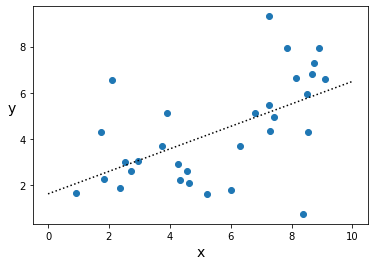

In [75]:
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/xkcd.csv'
df = pandas.read_csv(url)
x,y = df.x, df.y


def logPr(θ, x,y):
    σ = 0.5
    a,b = θ
    return np.log(scipy.stats.norm.pdf(y, loc=a+b*x, scale=σ))

initial_guess = [0,1]
ahat,bhat = scipy.optimize.fmin(lambda θ: -np.sum(logPr(θ, x,y)), initial_guess, maxiter=5000)

fig,ax = plt.subplots(figsize=(6,4))
xnew = np.linspace(0,10,100)
ax.plot(xnew, ahat+bhat*xnew, linestyle='dotted', color='black')
ax.scatter(x, y)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14, rotation='horizontal', ha='right')
plt.show()